# Notebook 0 - Exploration of the Data

## Section 0 - Import libraries and basic metadata

In [1]:
import os

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import wfdb

from bc.beats import get_beats, get_beat_bank
from bc.io import ann_to_df
from bc.plot import plot_beat, plot_four_beats

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

In [2]:
# View some records and their beats from the beat table
beat_table.head()

,N,L,R,A,a,J,S,V,F,!,e,j,E,P,f,p,Q
record,,,,,,,,,,,,,,,,,
100,2239,0,0,33,0,0,0,1,0,0,0,0,0,0,0,0,0
101,1860,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2
102,99,0,0,0,0,0,0,4,0,0,0,0,0,2028,56,0,0
103,2082,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
104,163,0,0,0,0,0,0,2,0,0,0,0,0,1380,666,0,18


## Section 1 - Inspect signal and annotation content

In [14]:
ann.contained_labels.loc[:, ['description', 'n_occurrences']]

,description,n_occurrences
symbol,,
L,Left bundle branch block beat,31
+,Rhythm change,2
V,Premature ventricular contraction,5
~,Signal quality change,4


,description,n_occurrences
symbol,,
L,Left bundle branch block beat,38
V,Premature ventricular contraction,1


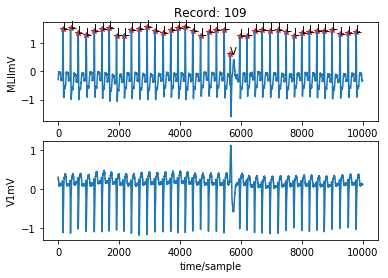

,description,n_occurrences
symbol,,
L,Left bundle branch block beat,31


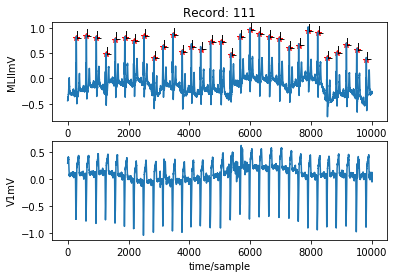

,description,n_occurrences
symbol,,
L,Left bundle branch block beat,12
R,Right bundle branch block beat,8
+,Rhythm change,4
V,Premature ventricular contraction,13


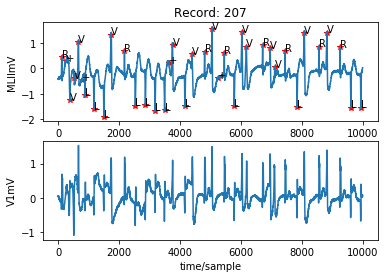

,description,n_occurrences
symbol,,
L,Left bundle branch block beat,31
+,Rhythm change,2
V,Premature ventricular contraction,5
~,Signal quality change,4


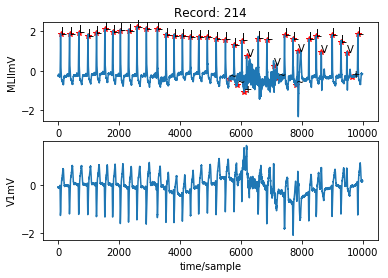

In [16]:
# Records with L: Left bundle branch block beat
l_records = beat_table.loc[beat_table['L']>0].index.values

# Visualize some records and annotations
for rec_name in l_records:
    # Load the signals and L beat annotations
    rec = wfdb.rdrecord(os.path.join(data_dir, rec_name), sampfrom=22000, sampto=32000)
    ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr',
                     sampfrom=22000, sampto=32000, shift_samps=True, summarize_labels=True)
    # Show the annotations contained in the files
    ann.contained_labels.set_index('symbol', inplace=True)
    display(ann.contained_labels.loc[:, ['description', 'n_occurrences']])
    wfdb.plot_wfdb(record=rec, annotation=ann, plot_sym=True)     

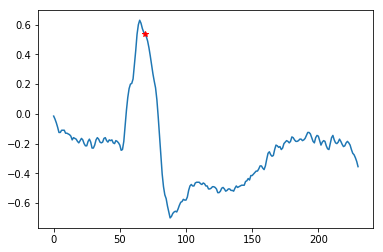

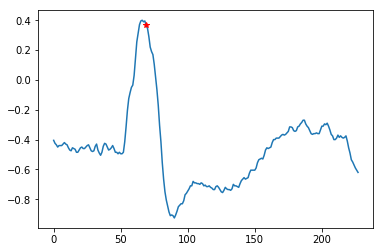

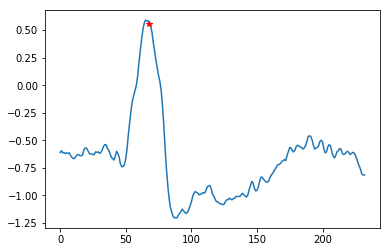

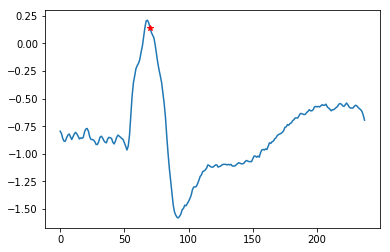

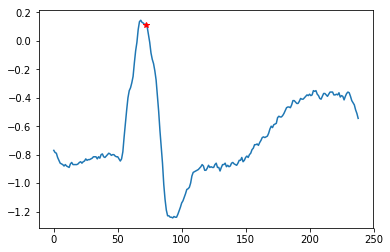

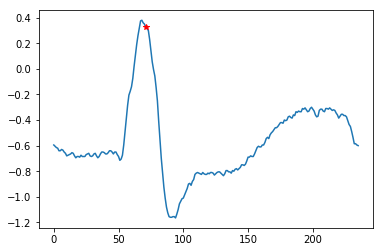

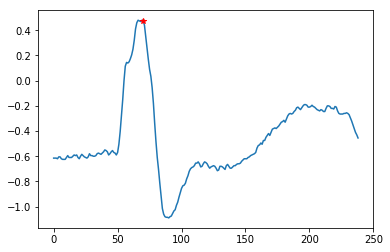

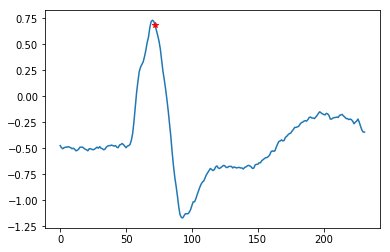

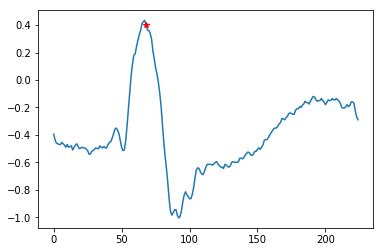

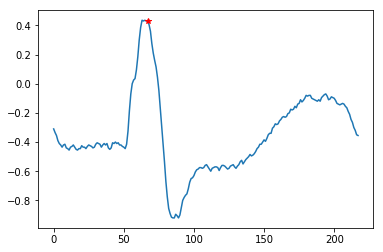

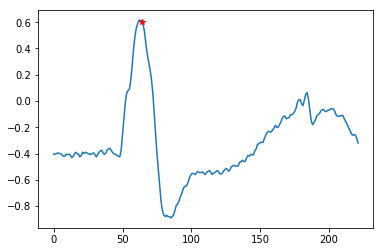

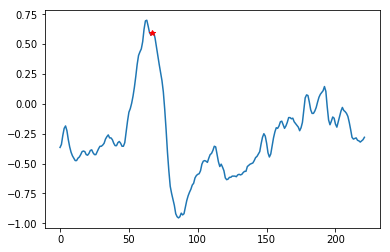

In [18]:
# Zoom in on some beats
# Load a record, extract some beats, and view them.
sig, fields = wfdb.rdsamp(os.path.join(data_dir, l_records[0]), sampto=3000)
ann = wfdb.rdann(os.path.join(data_dir, l_records[0]), extension='atr', sampto=3000)
# Get the peak samples and symbols in a dataframe. Remove the non-beat annotations
qrs_df = ann_to_df(ann, rm_sym=['+', '~'])
beats, centers = get_beats(sig=sig[:, 0], qrs_inds=qrs_df['sample'].values, 
                           beat_types = qrs_df['symbol'].values, wanted_type='L',
                           view=True)

## Section 2 - Load and Visualize Beat Types

In [4]:
# Extract all available L beats
l_beats, l_centers = [], []
for rec_name in l_records:
    # Load the signals and L beat annotations
    sig, fields = wfdb.rdsamp(os.path.join(data_dir, rec_name))
    ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr')
    # Get the peak samples and symbols in a dataframe. Remove the non-beat annotations
    qrs_df = ann_to_df(ann, rm_sym=['+', '~'])
    beats, centers = get_beats(sig=sig[:, 0], qrs_inds=qrs_df['sample'].values, 
                           beat_types = qrs_df['symbol'].values, wanted_type='L')
    l_beats += beats
    l_centers += centers

### Normal Beats

In [5]:
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='N')

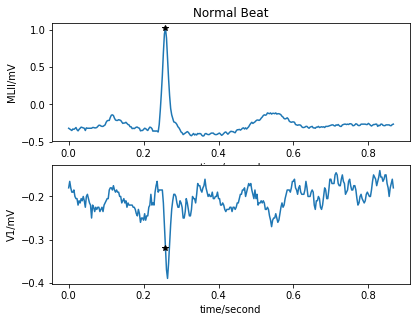

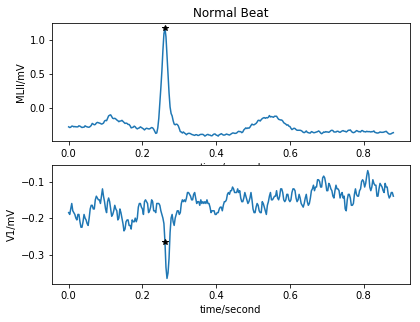

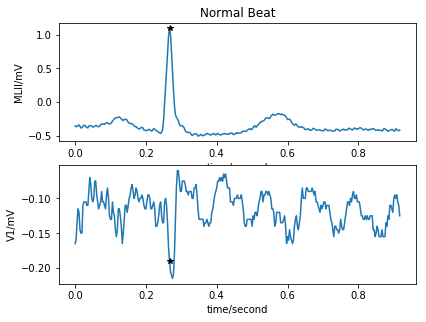

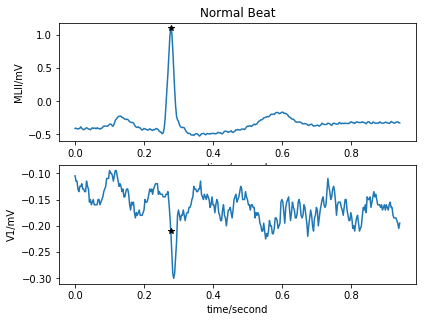

In [6]:
for i in range(4):
    plot_beat(n_beats[i], n_centers[i], title='Normal Beat')

### Left Bundle Branch Block

In [7]:
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='L')

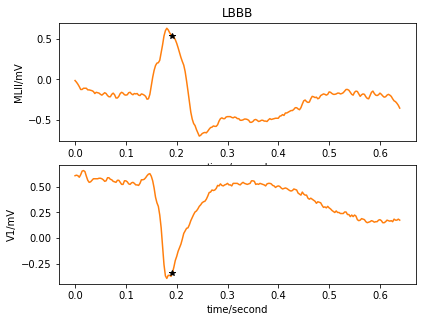

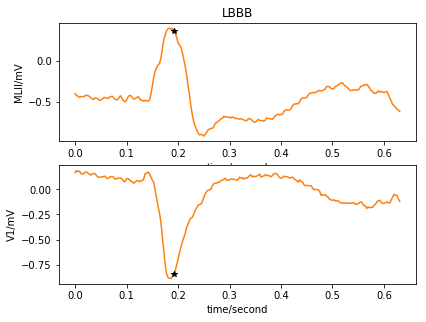

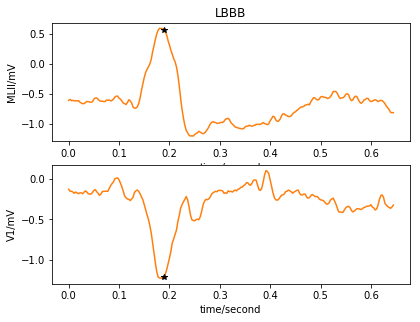

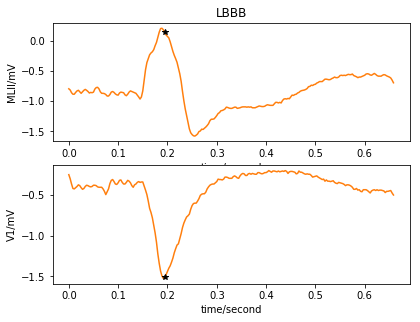

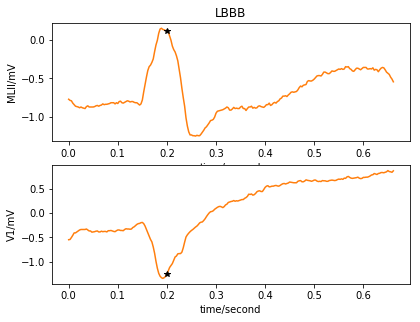

In [8]:
for i in range(5):
    plot_beat(l_beats[i], l_centers[i], style='C1', title='LBBB')

### Right Bundle Branch Block

In [9]:
r_beats, r_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='R')

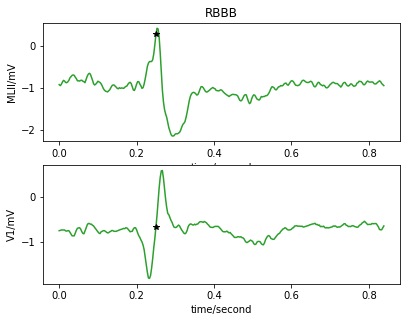

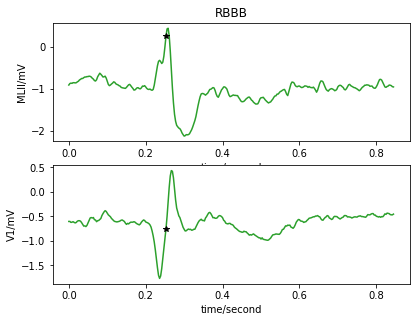

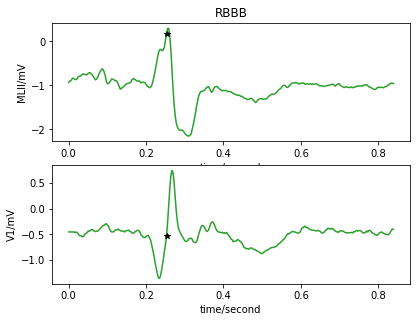

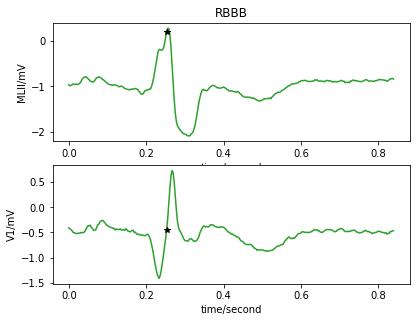

In [10]:
for i in range(4):
    plot_beat(r_beats[i], r_centers[i], style='C2', title='RBBB')

### Ventricular Premature Beat

In [11]:
v_beats, v_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='V')

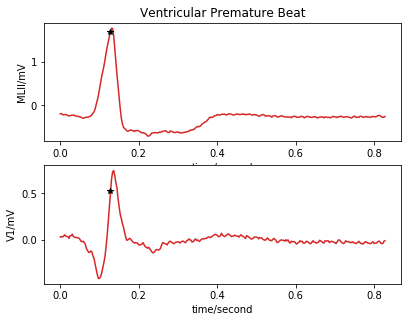

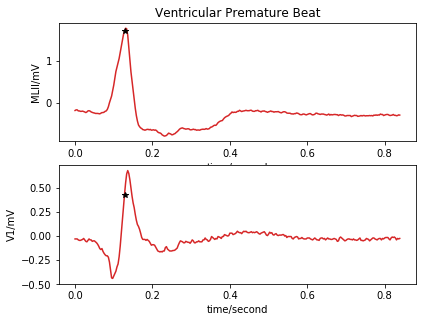

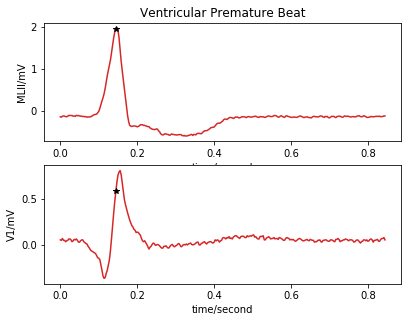

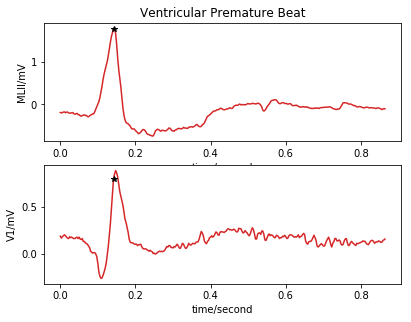

In [12]:
for i in range(4):
    plot_beat(v_beats[i], v_centers[i], style='C3', title='Ventricular Premature Beat')

In [14]:
# Compare all beats
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]])